here processed the film height fields with a fixed time interval. according Fourier frequencies was obtained wave characteristics

In [5]:
def init_matplotlib(name, font_path=None, fig_size_mm=(140, 70), dpi=150, 
                   font_size=12, output_format='jpg'):
    import matplotlib.font_manager as font_manager
    """Initialization params matplotlib with customizible parameters
    Args:
        name: matplotlib module (plt)
        font_path: the path to the font file
        fig_size_mm: the size of the figure in mm (width, height)
        dpi: resolution
        font_size: базовый размер шрифта
        output_format: формат сохранения
    """
    #reset to default settings
    name.rcParams.update(plt.rcParamsDefault)
    name.style.use('classic')
    #font settings with error handling
    if font_path is None:
        font_path = 'c:\\windows\\fonts\\times.ttf'
    try:
        prop = font_manager.FontProperties(fname=font_path)
        name.rcParams['font.family'] = prop.get_name()
    except (OSError, RuntimeError) as e:
        print(f"Warning: The {font_path} font could not be loaded. The default font is used. Error: {e}")
        name.rcParams['font.family'] = 'serif'
    #converting mm to inches
    fig_size_inch = (fig_size_mm[0] / 25.4, fig_size_mm[1] / 25.4)
    #grouping parameters for batch installation
    params = {
        #dimension and resolution
        "figure.figsize": fig_size_inch,
        "figure.dpi": dpi,
        "savefig.dpi": dpi,
        "savefig.format": output_format,
        #fonts
        "font.size": font_size,
        "axes.titlesize": font_size,
        "axes.labelsize": font_size,
        "xtick.labelsize": font_size,
        "ytick.labelsize": font_size,
        "legend.fontsize": font_size,
        #lines and msrkers
        "lines.linewidth": 0.5,
        "lines.markersize": 3.0,
        "lines.markeredgewidth": 1.0,
        "markers.fillstyle": 'none',
        #legend
        "legend.numpoints": 1,
        "legend.columnspacing": 1.5,
        "legend.handlelength": 2.0,
        #axes
        "axes.formatter.limits": (-7, 7),
        "axes.formatter.use_locale": True
    }
    name.rcParams.update(params)

#an alternative version with context return
def matplotlib_context(**kwargs):
    """
    Сontext manager for temporary application of settings
    """
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    from contextlib import contextmanager
    @contextmanager
    def context():
        original_params = mpl.rcParams.copy()
        try:
            init_matplotlib(plt, **kwargs)
            yield plt
        finally:
            mpl.rcParams.update(original_params)
    
    return context()

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import correlate

In [7]:
init_matplotlib(plt)

In [ ]:
filepath = r''
with open(filepath, 'r') as f:
    first_line = f.readline().strip() #1st strip
    #for structured mesh read width CV dx
    dxmesh = float(first_line)

In [9]:
data = pd.read_csv(filepath, sep=',', skiprows=1)
last_column_name = data.columns[-1]
nmax = int(last_column_name[1:])
lmax = nmax*dxmesh
print(f"dxmesh = {dxmesh:.4g}")
print(f"NMax = {nmax:.4g}")
print(f"LMax = {lmax:.4g}")

dxmesh = 7.651e-05
NMax = 1500
LMax = 0.1148


In [10]:
def N2X(n,dx):
    return n*dx
#choose points
n1 = 1000
xp1 = N2X(n1,dxmesh)
n2 = 1020
xp2 = N2X(n2,dxmesh)
print(f"delta21 = {xp2-xp1:.4g}")
name1 = "N" + str(n1)
name2 = "N" + str(n2)
tval = np.array(data["Time"])
delta1 = np.array(data[name1])
delta2 = np.array(data[name2])

delta21 = 0.00153


In [15]:
patch2fileout = './/figout//timesignal_'
init_matplotlib(plt)

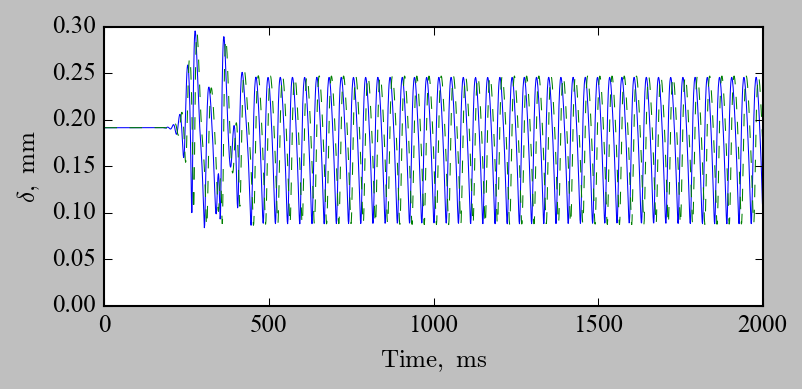

In [22]:
nameX = r'$\mathrm{Time,\ ms}$'
nameY = r'$\delta \mathrm{,\ mm}$'
fig, ax = plt.subplots(nrows=1,ncols = 1)
ax1 = ax
ax1.plot(tval*1.0e3,delta1*1.0e3,'-b',label = "-1")
ax1.plot(tval*1.0e3,delta2*1.0e3,'--g',label = "-2")
ax1.set_xlim(xmin = 0.0)
ax1.set_ylim(ymin = 0.0)
ax1.set_xlabel(nameX)
ax1.set_ylabel(nameY)
#ax1.set_xticks(np.arange(xmin,xmax+dx,dx))
#ax1.set_yticks(np.arange(ymin,ymax+dy,dy))
plt.savefig(patch2fileout, dpi=300, bbox_inches='tight')
plt.tight_layout()
plt.show()